In [1]:
%run base.ipynb
%load_ext autoreload
%autoreload 2

import gym
import matplotlib.pyplot as plt

from abides_gym_market_making_environment_v2 import *
from policies_v1 import SigPolicy
from train_v2 import train
from test_v1_v2 import test
import utils

## Register the environment

In [2]:
# register market making env for gym use 
from gym.envs.registration import register

register(
    id="market-making-v2",
    entry_point=SubGymMarketsMarketMakingEnv_v2,
)

def generate_env(seed=None):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(
            "market-making-v2",
            background_config="rmsc04",
            mkt_close="10:45:00",
            timestep_duration="10s",
            order_fixed_size=10,
            first_interval="00:10:00", #00:13:00
            observe_first_interval=False,
            max_inventory=100,
            mkt_order_alpha=0.2,
            terminal_inventory_reward=2,# reward
            inventory_reward_dampener=1., # 0.6,
            damp_mode="asymmetric",
            debug_mode=False
        )
    if seed is not None:
        env.seed(seed)
    
    return env

# create the environment
env = generate_env(3) #5

## Train a signature policy

In [3]:
episodes = 250
lr = 0.001
window_length = None
eps = 1.0
eps_decay = utils.linear_decay(epochs=20_000, start=eps, end=0.001)

sigpolicy = SigPolicy(env, 5)
sigpolicy.initialize_parameters(factor=1, zero_bias=True)

results = train(env, 
                sigpolicy, 
                episodes,
                discount=1.0,
                learning_rate=lr, 
                exploration="softmax",
                epsilon=eps,
                epsilon_decay=eps_decay,
                window_length=window_length, 
                printing=False)

  0%|          | 0/250 [00:00<?, ?it/s]
 Episode 0 | step 100 | reward -0.9569000000000001 | loss 0.07894234973591319
Q values: tensor([ 0.0312, -0.0295, -0.0039, -0.0060], grad_fn=<SelectBackward>)

 Episode 0 | step 200 | reward -3.6793 | loss 0.8797528263123808
Q values: tensor([-0.0108, -0.0493, -0.0482, -0.0379], grad_fn=<SelectBackward>)

 Episode 0 | step 300 | reward -4.397399999999999 | loss 0.9609459398162091
Q values: tensor([ 0.0151, -0.0821, -0.0726, -0.0356], grad_fn=<SelectBackward>)

 Episode 0 | step 391 | reward -4.899249999999999 | loss 1.026528331051308
Q values: tensor([ 0.0086,  0.0311, -0.2404, -0.0045], grad_fn=<SelectBackward>)
  0%|          | 1/250 [00:25<1:47:53, 26.00s/it]
 Episode 1 | step 400 | reward -0.027999999999999997 | loss 0.0010708907586831629
Q values: tensor([ 0.0042,  0.0270, -0.0182, -0.0042], grad_fn=<SelectBackward>)

 Episode 1 | step 500 | reward -1.1355 | loss 0.35640699244041096
Q values: tensor([ 0.0540,  0.0847, -0.0937, -0.0346], grad

#### Plot training results

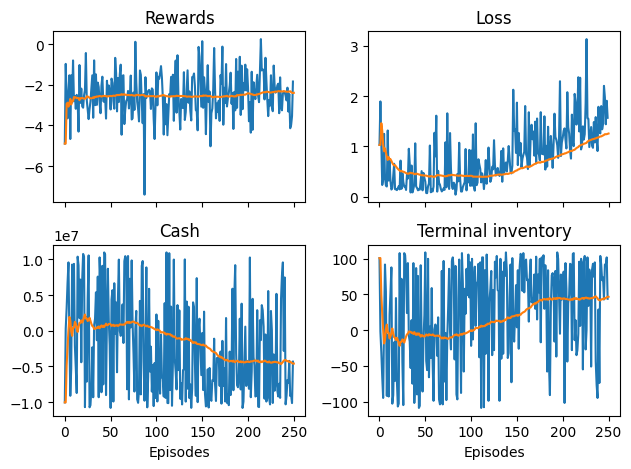

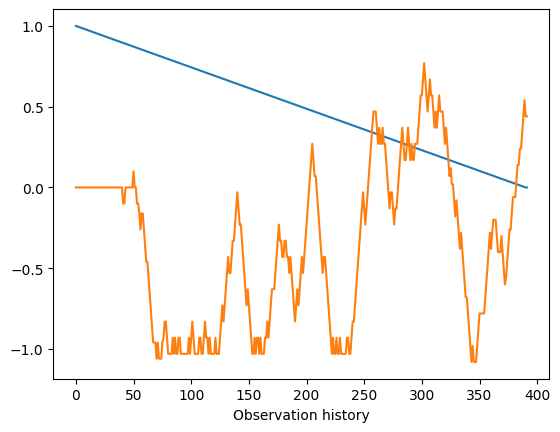

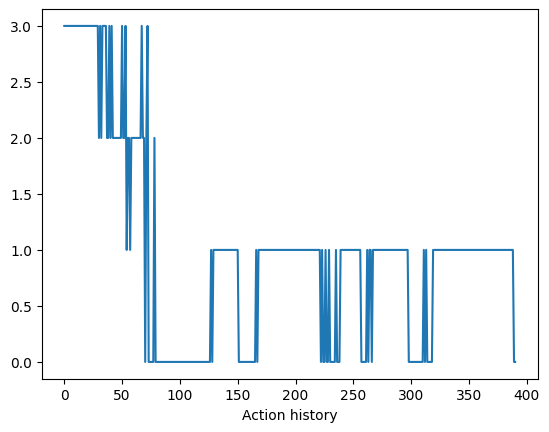

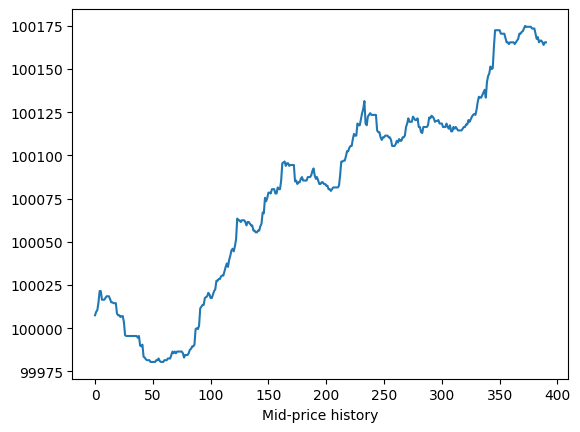

In [4]:

utils.plot_results([
    results["rewards"],
    results["losses"],
    results["cash"],
    results["terminal_inventory"],
])

id = -1

observation_history = list(results["observations"][id])
plt.plot(observation_history)
plt.xlabel("Observation history")
plt.show()

plt.plot(results["actions"][id])
plt.xlabel("Action history")
plt.show()

plt.plot(results["mid_prices"][id])
plt.xlabel("Mid-price history")
plt.show()


#### Save training results

In [5]:
# results_reduced_100_runs_0804_1  # without inventory reward
# results_reduced_50_runs_0804_2  # with inventory reward
# results_reduced_50_runs_0804_3 # with inventory reward and correct epsilon decay
# results_v2_200_runs_0808_1_convergence # inventory only model, with some convergence
# results_v2_250_runs_0809_1 # inventory only model, with convergence
# results_v2_250_runs_0809_2 # inventory only model, with convergence
# results_v2_250_runs_0810_1 # inventory only model, with convergence
# results_v2_250_runs_0811_1 # inventory only model, with no convergence
# results_v2_250_runs_0811_2 # inventory only model, with convergence
# results_v2_250_runs_0814_1 # inventory only model, with no convergence
# results_v2_250_runs_0814_2 # inventory only model, with no convergence
# results_v2_250_runs_0814_3 # inventory only model, with no convergence


import pickle

# write results 
with open('../results/results_NEW.pkl', 'wb') as f:  # open a text file
    pickle.dump(results, f) # serialize the list
f.close()

## Test a policy

#### Load training results

In [6]:
# results_reduced_100_runs_0804_1  # without inventory reward
# results_reduced_50_runs_0804_2  # with inventory reward
# results_reduced_50_runs_0804_3 # with inventory reward and correct epsilon decay
# results_v2_200_runs_0808_1_convergence # inventory only model, with some convergence
# results_v2_250_runs_0809_1 # inventory only model, with some convergence
# results_v2_250_runs_0809_2 # inventory only model, with some convergence
# results_v2_250_runs_0810_1 # inventory only model, with some convergence
# results_v2_250_runs_0811_1 # inventory only model, with no convergence
# results_v2_250_runs_0811_2 # inventory only model, with convergence


import pickle

# load results
with open('../results/results_v2_250_runs_0814_3.pkl', 'rb') as f:
    results = pickle.load(f)
f.close()

# load the parameters from saved checkpoint (every 10 episodes)
checkpoint = -1
sigpolicy = SigPolicy(env, 5)
sigpolicy.load_state_dict(results["intermediate"][checkpoint])

<All keys matched successfully>

#### Run tests

In [7]:
runs = 10
env = generate_env()
sigpolicy.eval()
test_results = test(env, sigpolicy, runs, epsilon=0)
sigpolicy.train()

  0%|          | 0/10 [00:00<?, ?it/s]
 3

 Episode 0 | step 100 | reward -0.11550000000000002 | inventory 0.75
Q values: tensor([[-0.6467, -0.6754, -0.6473, -0.6555]], grad_fn=<AddmmBackward>)

 Episode 0 | step 200 | reward -0.79585 | inventory 0.3700000047683716
Q values: tensor([[-0.6840, -0.6888, -0.6985, -0.7131]], grad_fn=<AddmmBackward>)

 Episode 0 | step 300 | reward -1.1871999999999998 | inventory 0.9700000286102295
Q values: tensor([[-1.0019, -1.0575, -1.0941, -1.0927]], grad_fn=<AddmmBackward>)

 Episode 0 | step 391 | reward -0.3987999999999996 | inventory 0.23000000417232513
Q values: tensor([[-0.8496, -0.7997, -0.9433, -0.9660]], grad_fn=<AddmmBackward>)
 10%|█         | 1/10 [00:25<03:50, 25.63s/it]
 3

 Episode 1 | step 400 | reward 0.0 | inventory 0.0
Q values: tensor([[-0.3746, -0.3710, -0.3621, -0.3550]], grad_fn=<AddmmBackward>)

 Episode 1 | step 500 | reward -0.1169 | inventory -0.7900000214576721
Q values: tensor([[-0.4292, -0.4392, -0.4327, -0.4415]], grad_fn=

SigPolicy(
  (linear): Linear(in_features=62, out_features=4, bias=True)
)

#### Plot testing results

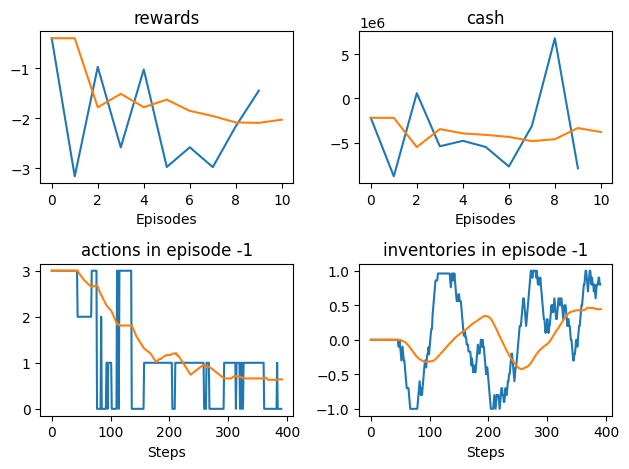

In [8]:
episode_id = -1
avg_window = 100
names = ["rewards", "cash", "actions", "inventories"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False)
for ax, id in zip(axes.flat, range(4)):
    ax.set_title(names[id] if id < 2 else names[id] + " in episode " + str(episode_id))
    ax.plot(test_results[names[id]] if id < 2 else test_results[names[id]][episode_id])
    ax.plot(utils.moving_average(
            test_results[names[id]] if id < 2 else test_results[names[id]][episode_id], avg_window
        ))
    ax.set_xlabel("Episodes" if id < 2 else "Steps")
fig.tight_layout()
plt.show()

#### Check first Q-value convergence

**Note**: We need to compare this with the average episode reward once all runs are performed. Also longer runs might be needed since I expect the average episode reward to be above the Q values reached with 250 episodes 

In [ ]:
import torch

policy = SigPolicy(env, 5)
first_history = list(results["observations"][0])[0:30]
first_history = torch.tensor(
    first_history, requires_grad=False, dtype=torch.float
).unsqueeze(0)
first_Q_values = []

for state_dict in results["intermediate"]: #range(len(results["intermediate"])):
    policy.eval()
    policy.load_state_dict(state_dict)    
    sig = policy.update_signature(first_history)  
    first_Q_values.append(policy(sig).detach())       

first_Q_values = torch.cat(first_Q_values, dim=0)
plt.plot(first_Q_values[:,3])


In [ ]:
import torch
import torch.nn.functional as F
t = torch.tensor([0.0978, 0.0893, 0.1016, 0.1024])
print(F.softmax(t, dim=-1))
print(F.softmax(t/0.02, dim=-1))
print(F.softmax(t/0.001, dim=-1))